# Procesamiento de Registros de Acceso a Moodle

Este notebook describe el proceso para procesar y analizar los patrones de acceso de los estudiantes a la plataforma Moodle. Como componente para la construcción del dataset destinado a la predicción del bajo rendimiento académico.

El objetivo principal es extraer y cuantificar los patrones de interacción de los estudiantes con la plataforma educativa Moodle, generando variables predictivas que puedan estar correlacionadas con el rendimiento académico. Específicamente busca:

Cuantificar la frecuencia y regularidad de acceso a la plataforma educativa
Identificar patrones temporales de estudio (días de la semana, jornadas preferidas)
Detectar períodos de inactividad prolongados

## Datos Utilizados

El procesador utiliza dos fuentes principales de datos:

Registros de eventos de Moodle (formato Parquet):

Contiene todos los eventos registrados en la plataforma Moodle, de los cuales se filtran los eventos de tipo login
Datos de matrícula de estudiantes (formato CSV):

### Registros Moodle (después de filtrado):

userid  | timecreated | eventname                  
--------|-------------|---------------------------
1025    | 1704967532  | \core\event\user_loggedin  
1046    | 1704967612  | \core\event\user_loggedin  
1089    | 1704968201  | \core\event\user_loggedin  

### Datos de Matrícula:

moodle_user_id | documento_identificación | id_grado | year
---------------|--------------------------|----------|-----
1025           | 1001234567               | 11A      | 2024
1046           | 1001234568               | 10B      | 2024
1089           | 1001234569               | 8C       | 2024


Paso a Paso
1. **Inicialización y Configuración**
- Se establecen los periodos académicos del año escolar (4 periodos)
- Se definen los periodos de vacaciones para excluirlos del cálculo del periodo de inactividad
2. **Extracción de Datos**
- Se extraen registros de login de los años 2024 y 2025
- Se realiza una unión con la información de matrícula para identificar grados y años académicos
- Se filtran únicamente eventos relevantes de tipo login
3. **Transformación y Preparación**
- Se estandarizan los formatos de fecha a la zona horaria local (Bogotá)
- Se asignan logins a periodos académicos específicos
- Se marcan los accesos realizados durante periodos vacacionales
4. **Generación de Variables Temporales**
- Clasificación de accesos por día de la semana para identificar patrones de regularidad
- Clasificación por jornada (madrugada, mañana, tarde, noche)
5. **Cálculo de Métricas de Engagement**
Para los accesos fuera de vacaciones, se calcula:
- El tiempo entre sesiones consecutivas para cada estudiante
- El período máximo de inactividad
6. **Agregación de Datos**
- Conteo total de logins por estudiante, año y periodo como medida de participación
- Distribución de accesos por día de la semana como indicador de regularidad
- Distribución por jornada para identificar preferencias de horario de estudio
- Consolidación de todas las métricas en un único conjunto de datos
7. **Generación del Dataset Final**  
Los datos procesados se guardan en formato CSV para su integración con otras fuentes de datos en el modelo predictivo general

### Dataset Resultante

El resultado final es un archivo CSV (data/interim/moodle/moodle_logins.csv) que contiene variables predictivas relacionadas con los patrones de acceso de cada estudiante:

**userid**: Identificador de usuario en Moodle  
**year**: Año académico  
**periodo**: Periodo académico (Periodo 1, Periodo 2, Periodo 3, Periodo 4)  
**count_login**: Número total de accesos (indicador de participación)  
**max_inactividad**: Máximo tiempo entre logins consecutivos (indicador de desconexión)  
**documento_identificación**: Número de documento del estudiante (para uniones posteriores)  
**count_login_mon** a **count_login_sun**: Distribución de accesos por día de la semana  
**count_jornada_madrugada**, **count_jornada_mañana**, etc.: Distribución de accesos por franja horaria  

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', '..'))
os.chdir(project_root)

# Añadir el directorio raíz al path de Python
if project_root not in sys.path:
    sys.path.append(project_root)

from scripts.eda_analyzer import EDAAnalyzer
from scripts.transform.moodle_login_processor import MoodleLoginProcessor

In [2]:
eda = EDAAnalyzer()
moodle_login_processor = MoodleLoginProcessor()

In [3]:
estudiantes_df = pd.read_csv("data/interim/estudiantes/estudiantes_imputed_encoded.csv", sep=",", encoding="utf-8")

In [5]:
enrolments_df = pd.read_csv("data/interim/estudiantes/enrollments.csv", sep=",", encoding="utf-8")

In [6]:
df_logins = pd.read_csv('data/interim/moodle/moodle_logins.csv', sep=',', encoding='utf-8')
df_logins

,userid,year,periodo,count_login,max_inactividad,documento_identificación,count_login_mon,count_login_tue,count_login_wed,count_login_thu,count_login_fri,count_login_sat,count_login_sun,count_jornada_madrugada,count_jornada_mañana,count_jornada_tarde,count_jornada_noche
0,1554,2025,1,1,1752.000000,945c83d3cff6cc83aaa392a985a62723db2acb618b7d40...,0,0,1,0,0,0,0,0,0,0,1
1,1555,2025,1,4,739.708611,dbda73a31c0eb86e5dff1b940753448583d57bd55c7cdb...,0,1,0,1,1,1,0,0,1,2,1
2,1558,2025,1,12,868.766389,6dc285f0f81324412fbf72f6ae7325d0e5c39c28f5eee6...,3,3,0,1,0,2,3,0,8,3,1
3,1560,2025,1,4,358.052500,1863c3df3ceaf0f38dbeb36e6b409284afb302b6e77a46...,0,2,0,1,1,0,0,0,0,4,0
4,1561,2024,1,32,337.827500,b8bd5170750ee52b2456363db9b3987fe2af7b89842474...,2,7,5,2,2,3,11,0,5,18,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,1995,2025,1,8,626.038333,513a54cfa8886cb02a2afae8cd6a787c373fe37635b648...,2,5,0,1,0,0,0,0,6,2,0
1355,1996,2025,1,2,290.986389,21fef1acaca579fcdca8509a0ea53de4daf80f03fad567...,1,0,0,0,0,1,0,0,2,0,0
1356,1997,2025,1,1,1752.000000,5acf93947f69980541f2ba2990642bf327736590847762...,0,1,0,0,0,0,0,0,0,1,0
1357,2000,2025,1,19,400.859167,a5607b9d2bdca49568a8b4c44925d3372790c03df27136...,2,6,6,2,2,0,1,0,10,4,5


In [7]:
enrolments_df

,documento_identificación,moodle_user_id,year,edukrea_user_id,id_grado,sede
0,b8bd5170750ee52b2456363db9b3987fe2af7b89842474...,1561,2024,NaN,1,Fusagasugá
1,a197ee802a1b5e306881a2ea9af366266ac2d1f4643272...,1562,2024,NaN,1,Fusagasugá
2,13d065def180ab40a3e0acc899c5524b4a437af268c0ec...,1563,2024,NaN,1,Fusagasugá
3,65778a71ac202c4eada1eb1cd76b30206b0546c7a34b25...,1564,2024,NaN,1,Fusagasugá
4,b6005ef089582419d97090147411273c47991bd937856d...,1565,2024,NaN,1,Fusagasugá
...,...,...,...,...,...,...
575,5acf93947f69980541f2ba2990642bf327736590847762...,1997,2025,339.0,2,Girardot
576,a5607b9d2bdca49568a8b4c44925d3372790c03df27136...,2000,2025,340.0,7,Fusagasugá
577,69a7a496c2e57c7b117869bcc305daf0eed608d6762ec0...,2001,2025,341.0,8,Girardot
578,c770616626bb56906040d885ccedae62ff67781227580f...,2003,2025,342.0,1,Girardot


In [8]:
df_logins = df_logins.merge(
    enrolments_df[['documento_identificación', 'id_grado']],
    left_on='documento_identificación',
    right_on='documento_identificación',
    how='left'
)

In [9]:
df_logins = df_logins.merge(
    estudiantes_df[['documento_identificación', 'sede']],
    left_on='documento_identificación',
    right_on='documento_identificación',
    how='left'
)

In [10]:
df_logins

,userid,year,periodo,count_login,max_inactividad,documento_identificación,count_login_mon,count_login_tue,count_login_wed,count_login_thu,count_login_fri,count_login_sat,count_login_sun,count_jornada_madrugada,count_jornada_mañana,count_jornada_tarde,count_jornada_noche,id_grado,sede
0,1554,2025,1,1,1752.000000,945c83d3cff6cc83aaa392a985a62723db2acb618b7d40...,0,0,1,0,0,0,0,0,0,0,1,1,Fusagasugá
1,1555,2025,1,4,739.708611,dbda73a31c0eb86e5dff1b940753448583d57bd55c7cdb...,0,1,0,1,1,1,0,0,1,2,1,1,Fusagasugá
2,1558,2025,1,12,868.766389,6dc285f0f81324412fbf72f6ae7325d0e5c39c28f5eee6...,3,3,0,1,0,2,3,0,8,3,1,1,Fusagasugá
3,1560,2025,1,4,358.052500,1863c3df3ceaf0f38dbeb36e6b409284afb302b6e77a46...,0,2,0,1,1,0,0,0,0,4,0,1,Fusagasugá
4,1561,2024,1,32,337.827500,b8bd5170750ee52b2456363db9b3987fe2af7b89842474...,2,7,5,2,2,3,11,0,5,18,9,1,Fusagasugá
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,1997,2025,1,1,1752.000000,5acf93947f69980541f2ba2990642bf327736590847762...,0,1,0,0,0,0,0,0,0,1,0,1,Girardot
2358,1997,2025,1,1,1752.000000,5acf93947f69980541f2ba2990642bf327736590847762...,0,1,0,0,0,0,0,0,0,1,0,2,Girardot
2359,2000,2025,1,19,400.859167,a5607b9d2bdca49568a8b4c44925d3372790c03df27136...,2,6,6,2,2,0,1,0,10,4,5,7,Fusagasugá
2360,2003,2025,1,19,88.670000,c770616626bb56906040d885ccedae62ff67781227580f...,13,3,1,0,0,0,2,0,2,7,10,1,Girardot


In [11]:
df_logins.isnull().sum()

userid                      0
year                        0
periodo                     0
count_login                 0
max_inactividad             0
documento_identificación    0
count_login_mon             0
count_login_tue             0
count_login_wed             0
count_login_thu             0
count_login_fri             0
count_login_sat             0
count_login_sun             0
count_jornada_madrugada     0
count_jornada_mañana        0
count_jornada_tarde         0
count_jornada_noche         0
id_grado                    0
sede                        0
dtype: int64

## Visualización de los datos

In [17]:
df_logins

,userid,year,periodo,count_login,max_inactividad,documento_identificación,count_login_mon,count_login_tue,count_login_wed,count_login_thu,count_login_fri,count_login_sat,count_login_sun,count_jornada_madrugada,count_jornada_mañana,count_jornada_tarde,count_jornada_noche,id_grado,sede
0,1554,2025,1,1,1752.000000,945c83d3cff6cc83aaa392a985a62723db2acb618b7d40...,0,0,1,0,0,0,0,0,0,0,1,1,Fusagasugá
1,1555,2025,1,4,739.708611,dbda73a31c0eb86e5dff1b940753448583d57bd55c7cdb...,0,1,0,1,1,1,0,0,1,2,1,1,Fusagasugá
2,1558,2025,1,12,868.766389,6dc285f0f81324412fbf72f6ae7325d0e5c39c28f5eee6...,3,3,0,1,0,2,3,0,8,3,1,1,Fusagasugá
3,1560,2025,1,4,358.052500,1863c3df3ceaf0f38dbeb36e6b409284afb302b6e77a46...,0,2,0,1,1,0,0,0,0,4,0,1,Fusagasugá
4,1561,2024,1,32,337.827500,b8bd5170750ee52b2456363db9b3987fe2af7b89842474...,2,7,5,2,2,3,11,0,5,18,9,1,Fusagasugá
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2357,1997,2025,1,1,1752.000000,5acf93947f69980541f2ba2990642bf327736590847762...,0,1,0,0,0,0,0,0,0,1,0,1,Girardot
2358,1997,2025,1,1,1752.000000,5acf93947f69980541f2ba2990642bf327736590847762...,0,1,0,0,0,0,0,0,0,1,0,2,Girardot
2359,2000,2025,1,19,400.859167,a5607b9d2bdca49568a8b4c44925d3372790c03df27136...,2,6,6,2,2,0,1,0,10,4,5,7,Fusagasugá
2360,2003,2025,1,19,88.670000,c770616626bb56906040d885ccedae62ff67781227580f...,13,3,1,0,0,0,2,0,2,7,10,1,Girardot


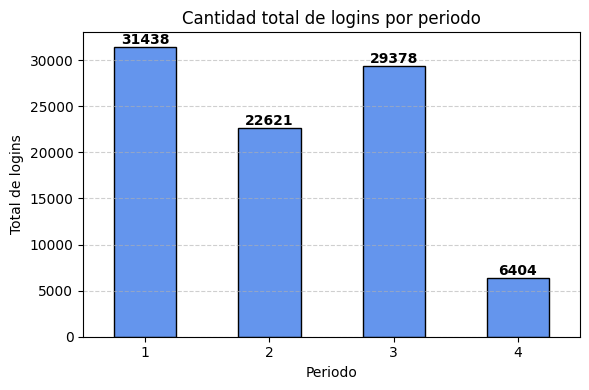

In [19]:
login_por_periodo = df_logins.groupby("periodo")["count_login"].sum()

# Graficar
plt.figure(figsize=(6, 4))
login_por_periodo.plot(kind="bar", color="cornflowerblue", edgecolor="black")

# Etiquetas
plt.title("Cantidad total de logins por periodo")
plt.xlabel("Periodo")
plt.ylabel("Total de logins")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Mostrar valores encima de las barras
for idx, valor in enumerate(login_por_periodo):
    plt.text(idx, valor + 0.5, int(valor), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

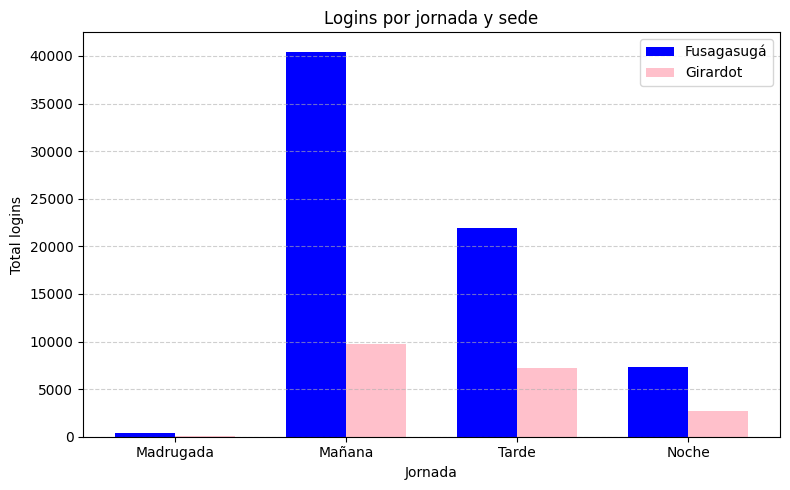

In [21]:
jornadas = ["count_jornada_madrugada", "count_jornada_mañana", "count_jornada_tarde", "count_jornada_noche"]
df_suma = df_logins.groupby("sede")[jornadas].sum()

# Renombrar columnas para visualización
df_suma.columns = ["Madrugada", "Mañana", "Tarde", "Noche"]
df_suma = df_suma.transpose()  # para que cada jornada sea una barra

# --- Graficar ---
plt.figure(figsize=(8, 5))

bar_width = 0.35
x = range(len(df_suma))

# Graficar barras por sede
plt.bar([i - bar_width / 2 for i in x], df_suma["Fusagasugá"], width=bar_width, label="Fusagasugá", color="blue")
plt.bar([i + bar_width / 2 for i in x], df_suma["Girardot"], width=bar_width, label="Girardot", color="pink")

# Etiquetas
plt.xticks(ticks=x, labels=df_suma.index)
plt.title("Logins por jornada y sede")
plt.xlabel("Jornada")
plt.ylabel("Total logins")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

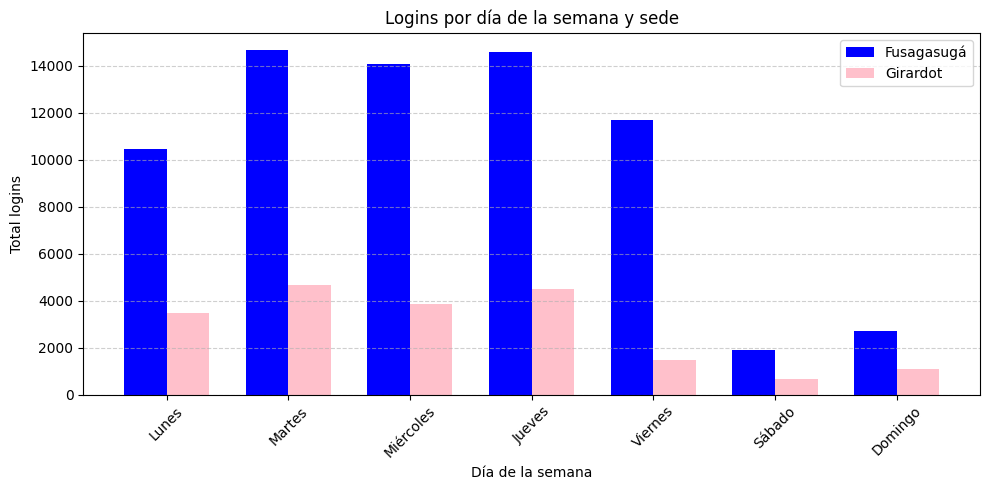

In [22]:
dias = [
    "count_login_mon", "count_login_tue", "count_login_wed",
    "count_login_thu", "count_login_fri", "count_login_sat", "count_login_sun"
]

# Agrupamos y sumamos
df_dias = df_logins.groupby("sede")[dias].sum()

# Renombramos columnas para visualización
df_dias.columns = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]
df_dias = df_dias.transpose()  # días como eje x

# --- Graficar ---
plt.figure(figsize=(10, 5))
bar_width = 0.35
x = range(len(df_dias))

plt.bar([i - bar_width / 2 for i in x], df_dias["Fusagasugá"], width=bar_width, label="Fusagasugá", color="blue")
plt.bar([i + bar_width / 2 for i in x], df_dias["Girardot"], width=bar_width, label="Girardot", color="pink")

# Etiquetas
plt.xticks(ticks=x, labels=df_dias.index, rotation=45)
plt.title("Logins por día de la semana y sede")
plt.xlabel("Día de la semana")
plt.ylabel("Total logins")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

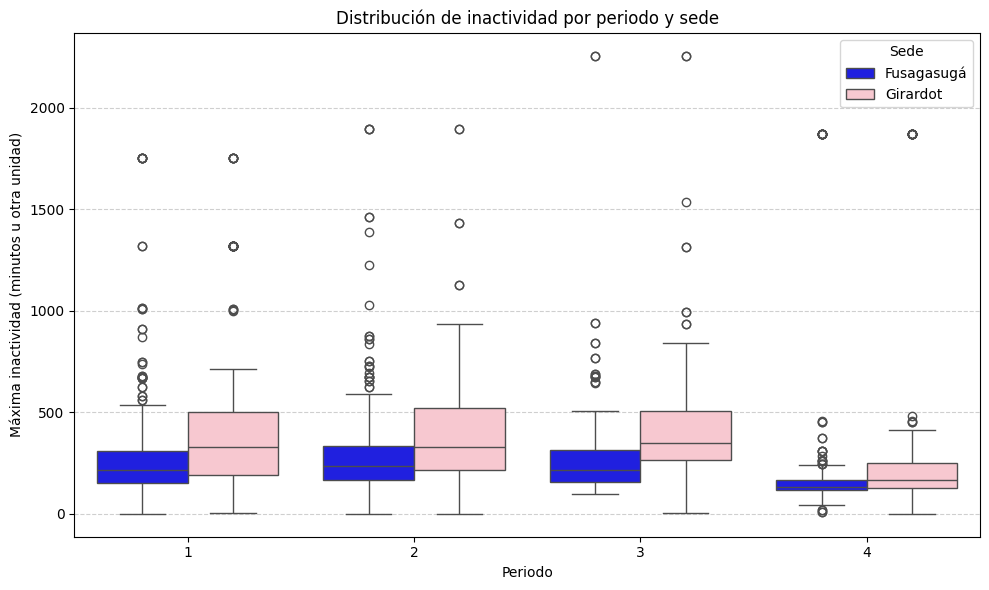

In [24]:
df_logins["max_inactividad"] = pd.to_numeric(df_logins["max_inactividad"], errors="coerce")

# Crear gráfico de cajas
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_logins, x="periodo", y="max_inactividad", hue="sede", palette={"Fusagasugá": "blue", "Girardot": "pink"})

# Configurar etiquetas
plt.title("Distribución de inactividad por periodo y sede")
plt.xlabel("Periodo")
plt.ylabel("Máxima inactividad (minutos u otra unidad)")
plt.legend(title="Sede")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

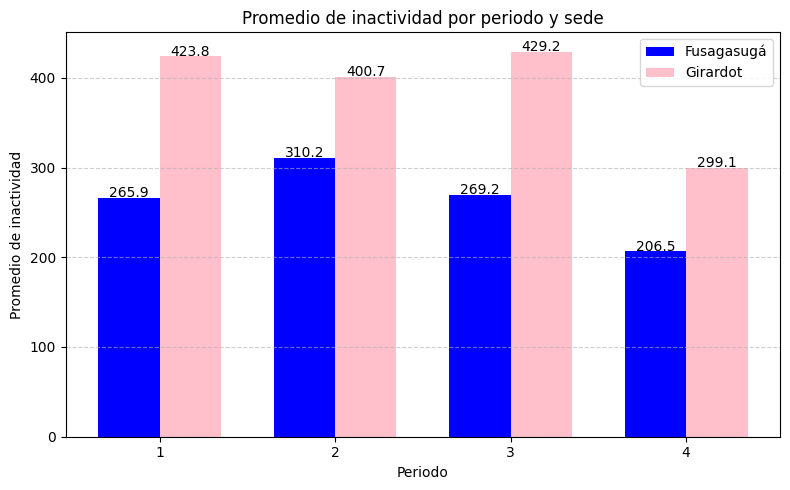

In [26]:
df_logins["max_inactividad"] = pd.to_numeric(df_logins["max_inactividad"], errors="coerce")

# Calcular promedio por periodo y sede
df_promedio = df_logins.groupby(["periodo", "sede"])["max_inactividad"].mean().unstack()

# --- Graficar ---
plt.figure(figsize=(8, 5))
bar_width = 0.35
x = range(len(df_promedio))

# Dibujar barras
plt.bar([i - bar_width / 2 for i in x], df_promedio["Fusagasugá"], width=bar_width, color="blue", label="Fusagasugá")
plt.bar([i + bar_width / 2 for i in x], df_promedio["Girardot"], width=bar_width, color="pink", label="Girardot")

# Etiquetas
plt.title("Promedio de inactividad por periodo y sede")
plt.xlabel("Periodo")
plt.ylabel("Promedio de inactividad")
plt.xticks(ticks=x, labels=df_promedio.index)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Mostrar valor numérico sobre cada barra
for i, (periodo, row) in enumerate(df_promedio.iterrows()):
    plt.text(i - bar_width / 2, row["Fusagasugá"] + 1, f"{row['Fusagasugá']:.1f}", ha='center')
    plt.text(i + bar_width / 2, row["Girardot"] + 1, f"{row['Girardot']:.1f}", ha='center')


plt.tight_layout()
plt.show()